Using Smopy means using OpenStreetMaps.  Per their usage rules: "Heavy use (e.g. distributing an app that uses tiles from openstreetmap.org) is forbidden without prior permission from the System Administrators. "

http://wiki.openstreetmap.org/wiki/Tile_usage_policy

In [1]:
import networkx as nx
import json
import numpy as np
import pandas as pd
import json
import smopy
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = mpl.rcParams['savefig.dpi'] = 300

## Defining the functions

In [2]:
#returns array of coordinates for any edge in the graph

def get_path(n0, n1):
    """If n0 and n1 are connected nodes in the graph, this function
    return an array of point coordinates along the road linking
    these two nodes."""
    return np.array(json.loads(g[n0][n1]['Json'])['coordinates'])

In [3]:
"""
    Our path contains connected nodes in the graph. 
    Every edge between two nodes is characterized by a list of points (constituting a part of the road). 
    Concatenates the positions along every edge in the path. 
"""

def get_full_path(path):
    """Return the positions along a path."""
    p_list = []
    curp = None
    for i in range(len(path)-1):
        p = get_path(path[i], path[i+1])
        if curp is None:
            curp = p
        if np.sum((p[0]-curp)**2) > np.sum((p[-1]-curp)**2):
            p = p[::-1,:]
        p_list.append(p)
        curp = p[-1]
    return np.vstack(p_list)

In [4]:
#plot nodes, a function sometimes called in plt_edge
def plt_node(a,b, color='black', size=1):
    
    for x,y in zip(a,b):
        ax.plot(x,y, 'o', color=color, ms=size, markeredgewidth=0.0)

In [107]:
def plt_edge(mini_path, color, plot_nodes=False, width=0.5):
    mini_linepath = get_full_path(mini_path)
    mx, my = map.to_pixels(mini_linepath[:,1], mini_linepath[:,0])
    ax.plot(mx, my, '-k', lw=width, color=color, alpha=0.6)
    if plot_nodes:
        plt_node(mx, my)

We will notably use the road path to compute its length. 
We first need to define a function that computes the distance between any two points in geographical coordinates. 
This function has been found in StackOverflow. 
http://stackoverflow.com/questions/8858838/need-help-calculating-geographical-distance

In [6]:
#returns in KILOMETERS
EARTH_R = 6372.8
def geocalc(lat0, lon0, lat1, lon1):
    """Return the distance (in km) between two points in 
    geographical coordinates."""
    lat0 = np.radians(lat0)
    lon0 = np.radians(lon0)
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    dlon = lon0 - lon1
    y = np.sqrt(
        (np.cos(lat1) * np.sin(dlon)) ** 2
         + (np.cos(lat0) * np.sin(lat1) 
         - np.sin(lat0) * np.cos(lat1) * np.cos(dlon)) ** 2)
    x = np.sin(lat0) * np.sin(lat1) + \
        np.cos(lat0) * np.cos(lat1) * np.cos(dlon)
    c = np.arctan2(y, x)
    return EARTH_R * c

In [7]:
#Now, we define a function computing a path's length.

#order of lats, lons was incorrect in tutorial! Corrected here
def get_path_length(path):
    return np.sum(geocalc(path[:-1,1], path[:-1,0], path[1:,1], path[1:,0]))

## Prep data

Load the data (a Shapefile dataset) with NetworkX. 
This dataset contains detailed information about all roads in San Francisco County. 
NetworkX's read_shp function returns a graph, where each node is a geographical position, 
and each edge contains information about the road linking the two nodes.

In lieu of Census data, SF Gov has a full, connected graph of streets that can be found here: https://data.sfgov.org/Geographic-Locations-and-Boundaries/Streets-of-San-Francisco/4ugn-hf48

In [8]:
g = nx.read_shp('Road files/geo_export_4d537b7d-a470-4eb9-b147-1d0ea89e6b60.shp')

#being directional means being unable to find edges unless in correct order
#so switch to unidirected
g = g.to_undirected()

sg_all = list(nx.connected_component_subgraphs(g.to_undirected()))

#grab the biggest subgraph
max_len = -1
sg_final = sg_all[0]
for sg in sg_all:
    x = len(sg)
    if x > max_len:
        max_len = x
        sg_final = sg
        
sg = sg_final

In [9]:
#update graph by computing the distance between any two connected nodes
for n0, n1 in sg_final.edges_iter():
    path = get_path(n0, n1)
    distance = get_path_length(path)
    sg.edge[n0][n1]['distance'] = distance

## Build route

In [23]:
#build a route between two points
def build_segment(a,b):
    segment = nx.shortest_path(sg_final, 
                        source=tuple(nodes[a]), 
                        target=tuple(nodes[b]),
                        weight='distance')
    return segment[1:]

In [56]:
#given a list of coordinates, return a path

def build_path(waypoints):
    #convert waypoints to node indexes
    waypoint_nodes = [np.argmin(np.sum((nodes[:,::-1] - w)**2, axis=1)) for w in waypoints]
    
    #seed with first node
    my_path = [tuple(nodes[waypoint_nodes[0]])]
    
    #iterate thru all but last, connecting this to next
    for i in range(len(waypoints)-1):
        my_path.extend(build_segment(waypoint_nodes[i], waypoint_nodes[i+1]))
        
    return my_path

In [101]:
#given a random point and the path, what is the lower-left and upper-right map points

def find_corners(point, my_paths):
    #this finds the lowest & highest lat/lon even if not directly paired
    ll_lat = point[0]
    ll_lon = point[1]
    ur_lat = point[0]
    ur_lon = point[1]

    for mp in my_paths:
        for p in mp:
            if p[1] < ll_lat:
                ll_lat = p[1]
            if p[0] < ll_lon:
                ll_lon = p[0]
            if p[1] > ur_lat:
                ur_lat = p[1]
            if p[0] > ur_lon:
                ur_lon = p[0]

    return (ll_lat, ll_lon), (ur_lat, ur_lon)

In [109]:
#build up color list
colors = ['blue', 'red', 'green']

#build up target blocks
targets = [[(37.800509, -122.426759), (37.800740, -122.426124)],
           [(37.802056, -122.423589), (37.801861, -122.424581)],
           [(37.799405, -122.420413), (37.799057, -122.420381)]]

In [10]:
#notable spots
home = (37.790461, -122.428311)
work = (37.789006, -122.409448)

## define the key areas of the route
start = home
end = home

In [96]:
#for each set of targets, iterate through and build a route, calculate the distance and store in a list of routes

paths = [] 

for ti in range(len(targets)):
    target = targets[ti]

    #compile all waypoints
    my_route = [start]
    my_route.extend(target)
    my_route.extend([end])

    #send coordinates, receive path, add to master list
    path = build_path(my_route)
    paths.append(path)

    #calc distance
    roads = pd.DataFrame([sg.edge[path[i]][path[i + 1]] 
                          for i in range(len(path) - 1)], 
                         columns=['distance', 'nhood', 'streetname'])

    #total length of this itinerary, adjust from km to miles
    print('route #' + str(ti) + ' ' +\
        str(round(roads['distance'].sum() * 0.621371, 2)) + ' mi (' +\
         colors[ti] + ')')

route #0 1.95 mi (blue)
route #1 2.45 mi (red)
route #2 2.21 mi (green)


Lowered zoom level to keep map size reasonable. (z = 16)


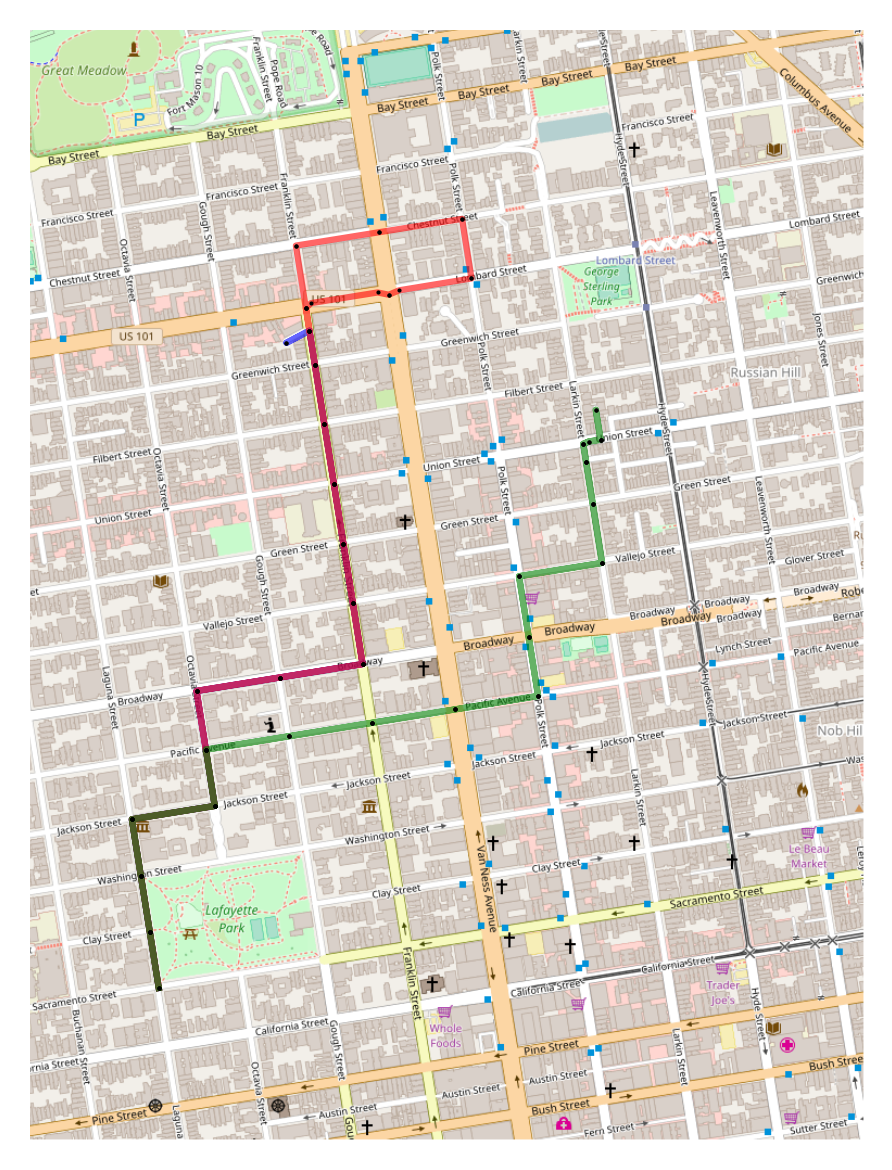

In [108]:
#display the itinerary on the map

path_ll, path_ur = find_corners(start, paths)

map = smopy.Map(path_ll, path_ur)

ax = map.show_mpl()

for p_i in range(len(paths)):
    plt_edge(paths[p_i], colors[p_i], True, width=1.5)

## scratch

In [103]:
find_corners(start, my_paths)

NameError: name 'my_paths' is not defined

In [61]:
end

(37.790461, -122.428311)

In [50]:
np.argmin(np.sum((nodes[:,::-1] - start)**2, axis=1))

2023

In [53]:
np.argmin(np.sum((nodes[:,::-1] - abc)**2, axis=1))

ValueError: operands could not be broadcast together with shapes (8920,2) (4,2) 